.ipynb folder for testing model collapse on two general machine learning models: random forest & linear regression. 

To start, there will be several tests of the machine learning models to try and maximize accuracy before the 

Setup: import libraries, create dataset, etc. 

In [23]:
                 

# using alexhusted's random forest project as reference for implementing random forest
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import SkLearn
from sklearn import tree, preprocessing
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score


                

In [24]:
# dataset with pandas
url = "https://archive.ics.uci.edu/static/public/186/data.csv"
wine_data = pd.read_csv(url, sep=',')

In [25]:
# change red -> 0, white -> 1 so they're useable in the model
color = {'red': 0,'white': 1} 
wine_data.color = [color[item] for item in wine_data.color] 
#print(wine_data.describe())
print()
print(wine_data.dtypes)


fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                     int64
dtype: object


Correlation Matrix: I'm using a correlation matrix to examine which categories in the dataset have too strong of a correlation with other categories so that they can be removed to prevent overfitting. 

<Axes: >

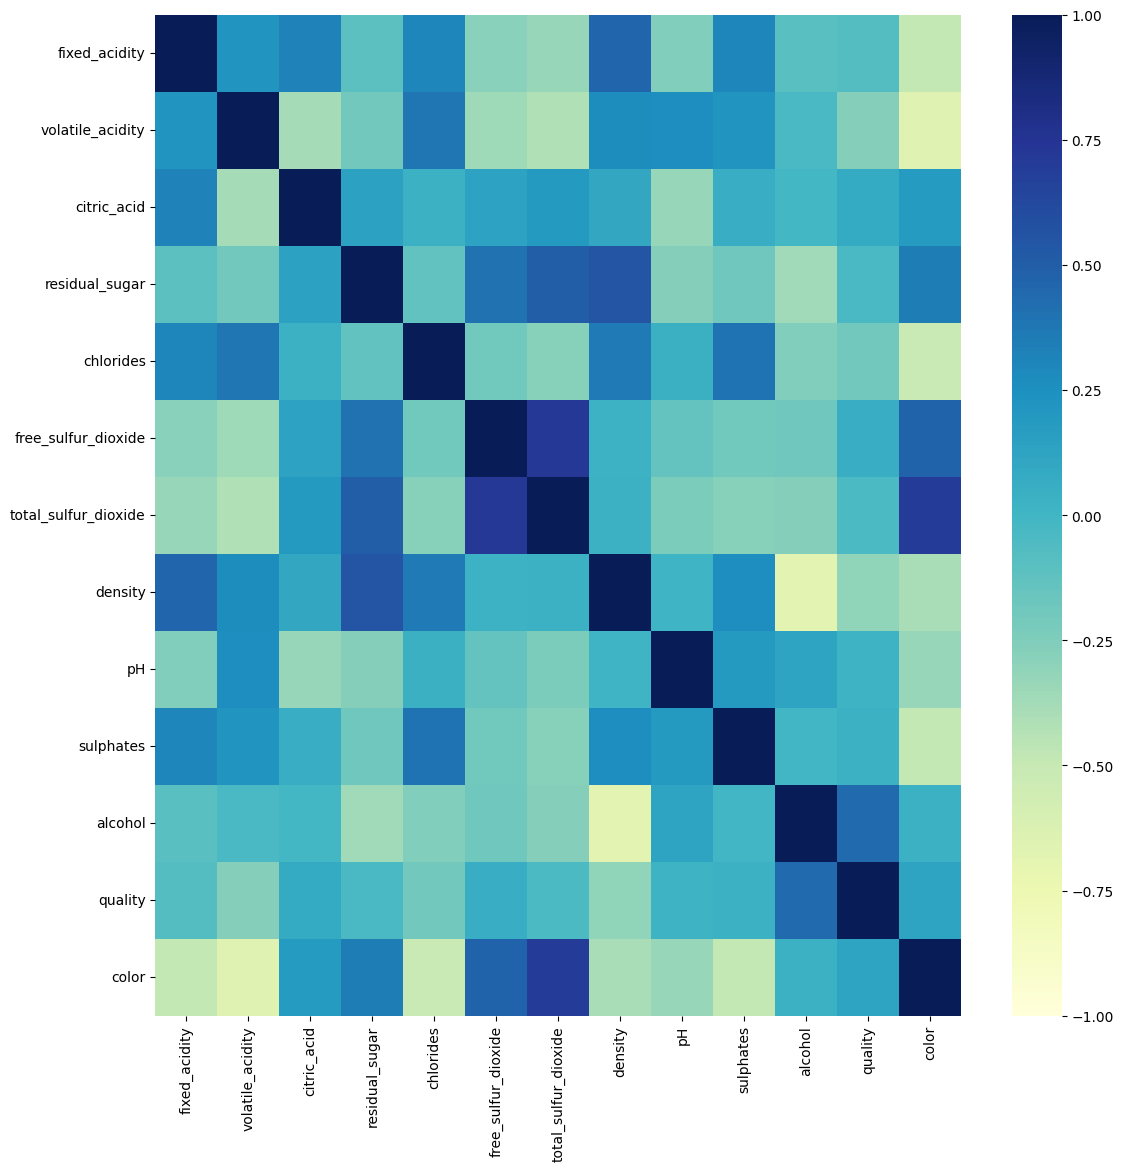

In [26]:
corr_matrix = wine_data.corr()
#print(corr_matrix)
# Plot the new correlation matrix based upon the created dataframe 'corr_df'
plt.figure(figsize=(13,13))
sns.heatmap(corr_matrix, cmap='YlGnBu', vmin=-1, vmax=1)

In [27]:
# Remove the "total_sulfur_dioxide" category because of high correlations
wine_data_init = wine_data
wine_data = wine_data.drop('total_sulfur_dioxide', axis=1)

# drop a row to keep totals even


In [28]:
# Remove red wine entries (and 'color' category) because skew of data
#wine_data = wine_data[wine_data.color != 0]
#wine_data = wine_data.drop('color', axis=1)

Random Forest Model

In [29]:
# create datasets with and without 'quality'
Xa1 = wine_data.drop(['quality'], axis=1)
ya1 = wine_data['quality']

In [30]:
# train/test split on the data
# doing 50% split because of equal data in repeated generations
Xa1_train, Xa1_test, ya1_train, ya1_test = train_test_split(Xa1, ya1, test_size=0.5, random_state=321)

# normalize the sizes of the dataframes
Xa1_test = Xa1_test.tail(-1)
ya1_test = ya1_test.tail(-1)

#confirm the data
print(Xa1_test)
print(ya1_test)
print(Xa1_train)
print(ya1_train)

      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
4435            6.5              0.22         0.45            8.00      0.053   
1099            8.6              0.52         0.38            1.50      0.096   
4261            7.0              0.23         0.33            1.00      0.043   
1925            7.9              0.26         0.41           15.15      0.040   
2186            6.1              0.32         0.25            1.70      0.034   
...             ...               ...          ...             ...        ...   
2055            6.3              0.23         0.31            1.50      0.022   
6082            5.8              0.28         0.18            1.20      0.058   
3343            6.6              0.22         0.58            1.10      0.133   
4541            6.8              0.26         0.46            8.30      0.037   
5791            6.7              0.20         0.24            6.50      0.044   

      free_sulfur_dioxide  

In [31]:
# initialize rf model (sklearn)
rf_model = RandomForestClassifier(n_estimators=100)
# fit the model on the train data
rf_model.fit(Xa1_train, ya1_train)

RandomForestClassifier()

Examining Results

In [32]:
# Print the model score based upon the random forest classifier
acc1 = rf_model.score(Xa1_test,ya1_test)
print(acc1)

0.6517857142857143


In [33]:
def generate_synthetic_features(rf_model, num_samples, X_train):
    synthetic_samples = []
    feature_names = X_train.columns

    # Precompute min and max for each feature
    feature_min = X_train.min()
    feature_max = X_train.max()

    # Iterate until we have generated the required number of synthetic samples
    while len(synthetic_samples) < num_samples:
        # Choose a random tree from the Random Forest
        random_tree = random.choice(rf_model.estimators_)
        tree = random_tree.tree_
        
        # Create an empty synthetic sample with NaN values
        synthetic_sample = np.full(len(feature_names), np.nan)
        
        # Start from the root node and traverse until a leaf is reached
        node_id = 0  # Start at the root node
        
        while tree.children_left[node_id] != tree.children_right[node_id]:
            left_child = tree.children_left[node_id]
            right_child = tree.children_right[node_id]
            feature = tree.feature[node_id]
            threshold = tree.threshold[node_id]

            # Get number of samples going left and right
            n_node_samples = tree.n_node_samples[node_id]
            n_left = tree.n_node_samples[left_child]
            n_right = tree.n_node_samples[right_child]

            # Compute probabilities
            p_left = n_left / n_node_samples
            p_right = n_right / n_node_samples

            # Decide to go left or right based on probabilities
            if random.random() < p_left:
                # Go to the left child (value <= threshold)
                min_val = feature_min[feature_names[feature]]
                max_val = threshold
                node_id = left_child
            else:
                # Go to the right child (value > threshold)
                min_val = threshold
                max_val = feature_max[feature_names[feature]]
                node_id = right_child

            # Sample a value for the feature (if not already set)
            if np.isnan(synthetic_sample[feature]):
                synthetic_sample[feature] = random.uniform(min_val, max_val)
            
        # For features not set, assign random values within min and max
        for i in range(len(feature_names)):
            if np.isnan(synthetic_sample[i]):
                synthetic_sample[i] = random.uniform(feature_min[feature_names[i]], feature_max[feature_names[i]])

        # Append the generated sample to the list
        synthetic_samples.append(synthetic_sample)
    
    # Convert the list of synthetic samples to a DataFrame
    X_synthetic = pd.DataFrame(synthetic_samples, columns=feature_names)

    return X_synthetic

Iteration 1: Accuracy = 0.5203
Confusion Matrix:
[[   0    0    5    9    0    0    0]
 [   0    0   39   70    0    0    0]
 [   0    0  541  564    0    0    0]
 [   0    0  248 1143    1    0    0]
 [   0    0   19  502    6    0    0]
 [   0    0    0   97    3    0    0]
 [   0    0    0    1    0    0    0]]

Iteration 2: Accuracy = 0.5203
Confusion Matrix:
[[   0    0    4   10    0    0    0]
 [   0    0   38   71    0    0    0]
 [   0    0  571  534    0    0    0]
 [   0    0  273 1119    0    0    0]
 [   0    0   21  506    0    0    0]
 [   0    0    5   95    0    0    0]
 [   0    0    0    1    0    0    0]]

Iteration 3: Accuracy = 0.5102
Confusion Matrix:
[[   0    0    4   10    0    0    0]
 [   0    0   33   76    0    0    0]
 [   0    0  479  626    0    0    0]
 [   0    0  214 1178    0    0    0]
 [   0    0   25  502    0    0    0]
 [   0    0    4   96    0    0    0]
 [   0    0    0    1    0    0    0]]

Iteration 4: Accuracy = 0.5222
Confusion Matrix:


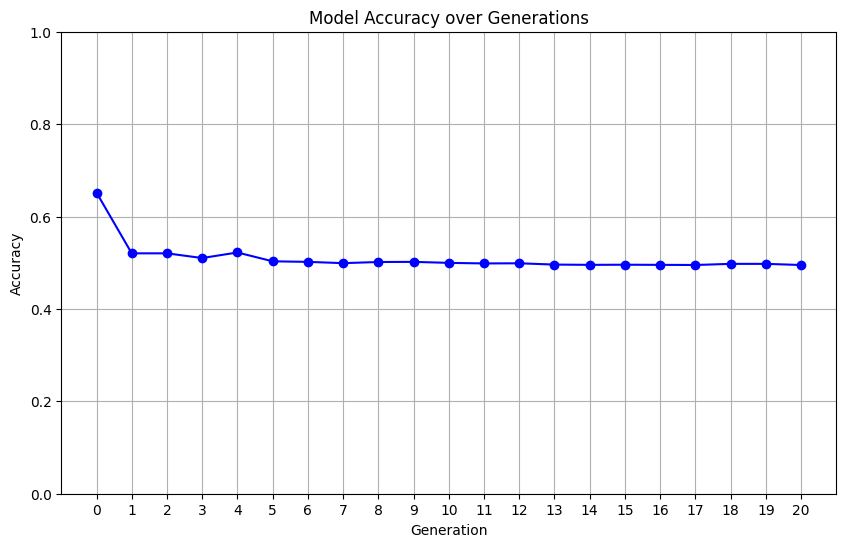

In [34]:
accuracies = []
accuracies.append(acc1)
iterations = []
iterations.append(0)

X_synthetic = generate_synthetic_features(rf_model, 3248, Xa1_train)

for i in range(1, 21):
    # Step 1: Generate new synthetic features based on current training set
    X_synthetic = generate_synthetic_features(rf_model, 3248, X_synthetic)
    
    # Step 2: Use the current model to predict labels for the synthetic data
    y_synthetic = rf_model.predict(X_synthetic)
    
    # Step 4: Train a new Random Forest model on the synthetic dataset
    rf_model = RandomForestClassifier(n_estimators=100)
    rf_model.fit(X_synthetic, y_synthetic)
    
    # Step 5: Evaluate the new model on the original fixed test set
    y_test_pred = rf_model.predict(Xa1_test)
    accuracy = accuracy_score(ya1_test, y_test_pred)
    
    # Print the iteration and accuracy
    print(f"Iteration {i}: Accuracy = {accuracy:.4f}")
    cm = confusion_matrix(y_true=ya1_test, y_pred=y_test_pred)
    print(f"Confusion Matrix:\n{cm}\n")
    
    # Append the accuracy and iteration number to the lists
    accuracies.append(accuracy)
    iterations.append(i)

# After the loop, plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(iterations, accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy over Generations')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.xticks(iterations)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

Run the generations

In [35]:
# Display the confusion matrix
y_pred = rf_model.fit(Xa1_train, ya1_train).predict(Xa1_test)
cm = confusion_matrix(y_true = ya1_test, y_pred = y_pred)
print(cm)

[[   0    0    6    8    0    0    0]
 [   0    9   62   37    1    0    0]
 [   0    5  735  355   10    0    0]
 [   0    0  220 1082   90    0    0]
 [   0    0   11  251  265    0    0]
 [   0    0    0   42   40   18    0]
 [   0    0    0    0    1    0    0]]


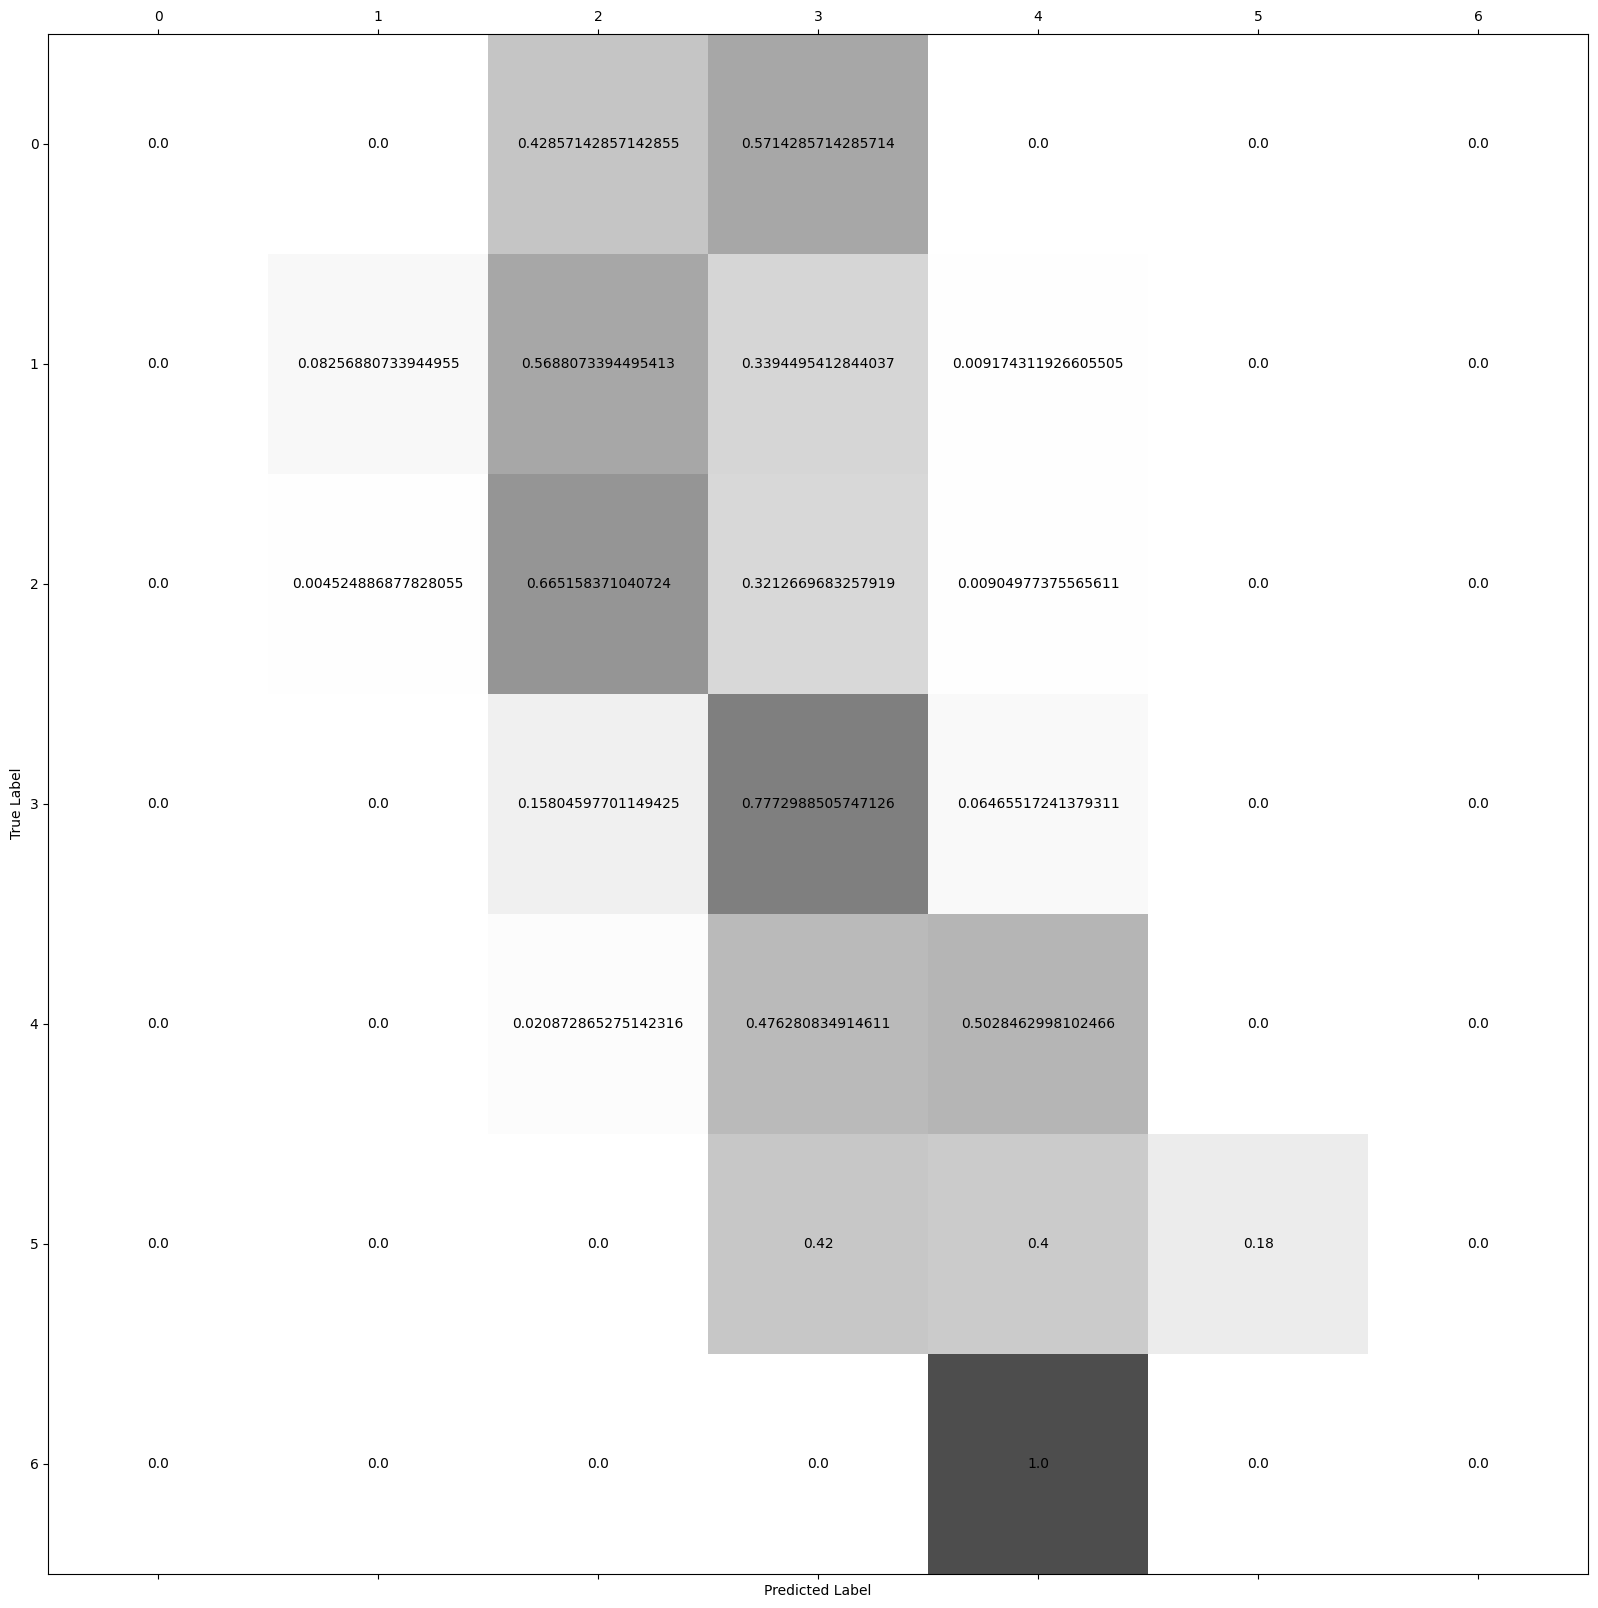

In [36]:
# Plot the Predicted Label vs. True Label accuracy matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig,ax = plt.subplots(figsize=(20,20))
ax.matshow(cmn, cmap=plt.cm.Greys, alpha=0.7)
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        ax.text(x=j, y=i, s=cmn[i,j], va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

[[   0    0    5    9    0    0    0]
 [   0    0   29   80    0    0    0]
 [   0    0  575  530    0    0    0]
 [   0    0  359 1033    0    0    0]
 [   0    0   52  475    0    0    0]
 [   0    0    5   95    0    0    0]
 [   0    0    0    1    0    0    0]]


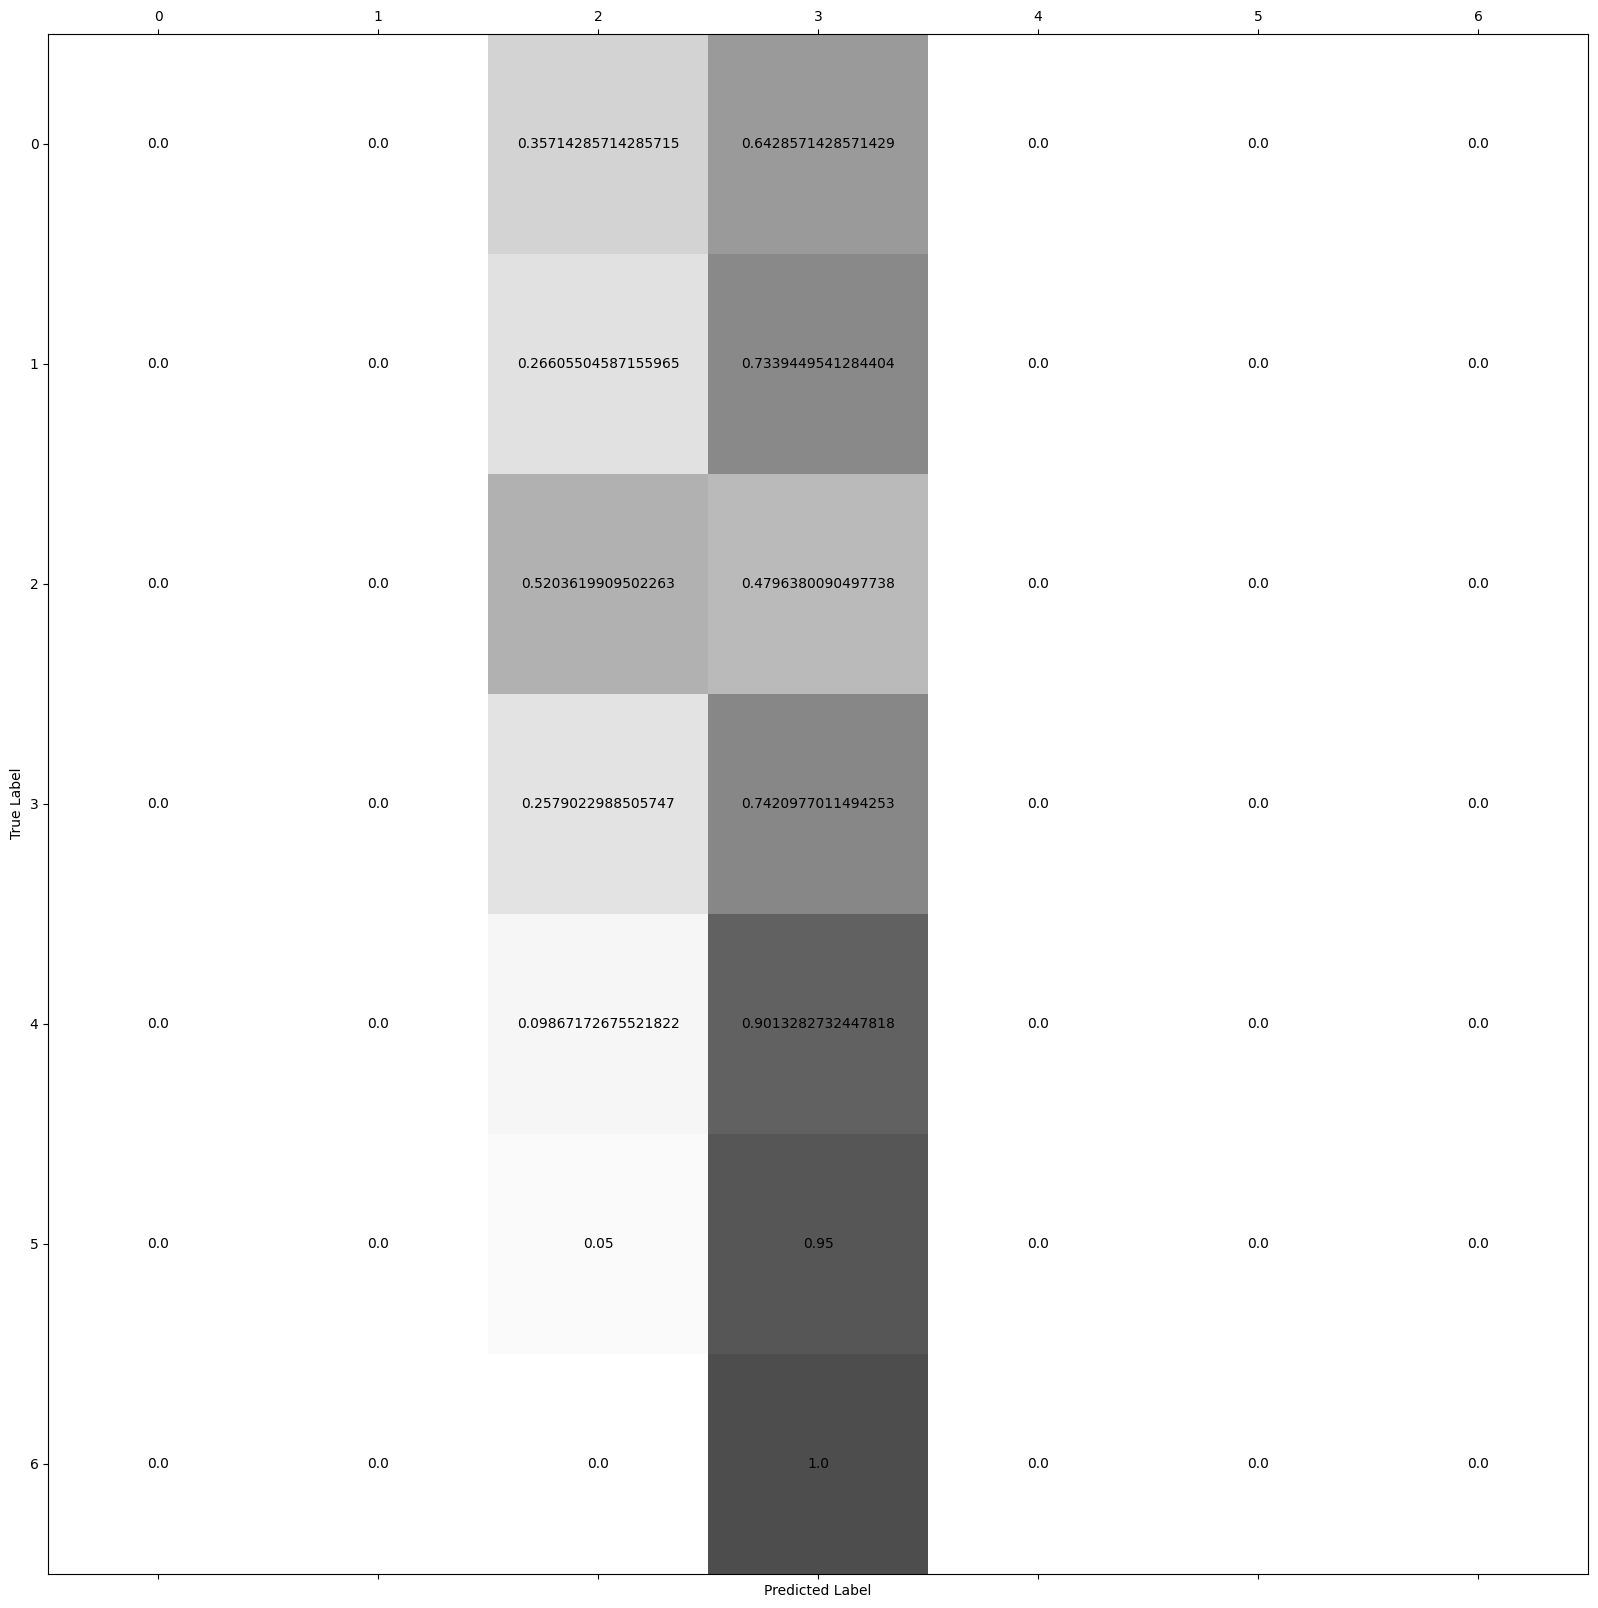

In [37]:
y_pred = rf_model.fit(X_synthetic, y_synthetic).predict(Xa1_test)
cm = confusion_matrix(y_true = ya1_test, y_pred = y_pred)
print(cm)

# Plot the Predicted Label vs. True Label accuracy matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig,ax = plt.subplots(figsize=(20,20))
ax.matshow(cmn, cmap=plt.cm.Greys, alpha=0.7)
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        ax.text(x=j, y=i, s=cmn[i,j], va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Using 'color' as the target variable instead

In [38]:
# create datasets with and without 'color', with 'quality' added back
wine_data_init = wine_data_init.drop('free_sulfur_dioxide', axis=1)
Xb1 = wine_data_init.drop('color', axis=1)
yb1 = wine_data_init['color']

In [39]:
# train/test split on the data
# doing 50% split because of equal data in repeated generations
Xb1_train, Xb1_test, yb1_train, yb1_test = train_test_split(Xb1, yb1, test_size=0.5, random_state=123)
# normalize the sizes of the dataframes
Xb1_test = Xb1_test.tail(-1)
yb1_test = yb1_test.tail(-1)

#confirm the data
print(Xb1_test)
print(yb1_test)
print(Xb1_train)
print(yb1_train)

      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
2767            7.2              0.20         0.38            1.00      0.037   
5069            6.7              0.24         0.30            3.85      0.042   
5780            6.6              0.25         0.32            5.60      0.039   
547            10.6              0.31         0.49            2.50      0.067   
1769            7.1              0.30         0.46            1.50      0.066   
...             ...               ...          ...             ...        ...   
2332            6.6              0.25         0.30           14.40      0.052   
1920            6.6              0.24         0.35            7.70      0.031   
3125           14.2              0.27         0.49            1.10      0.037   
44              6.8              0.67         0.02            1.80      0.050   
789             8.6              0.63         0.17            2.90      0.099   

      total_sulfur_dioxide 

In [40]:
# initialize rf model (sklearn)
rf_model = RandomForestClassifier(n_estimators=100)
# fit the model on the train data
rf_model.fit(Xb1_train, yb1_train)
# Print the model score based upon the random forest classifier
acc1 = rf_model.score(Xb1_test,yb1_test)
print(acc1)

0.9938423645320197


In [41]:
# Display the confusion matrix
y_pred = rf_model.fit(Xb1_train, yb1_train).predict(Xb1_test)
cm = confusion_matrix(y_true = yb1_test, y_pred = y_pred)
print(cm)

[[ 790   15]
 [   5 2438]]


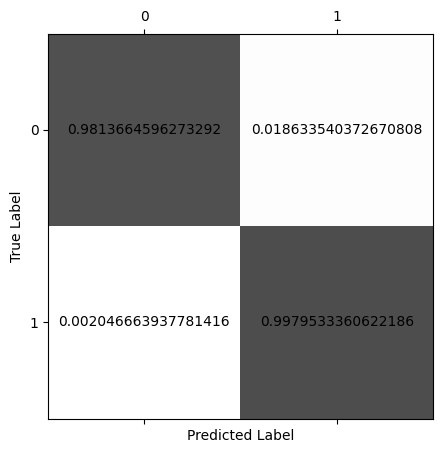

In [42]:
# Plot the Predicted Label vs. True Label accuracy matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig,ax = plt.subplots(figsize=(5,5))
ax.matshow(cmn, cmap=plt.cm.Greys, alpha=0.7)
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        ax.text(x=j, y=i, s=cmn[i,j], va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Iteration 1: Accuracy = 0.9744
Confusion Matrix:
[[ 724   81]
 [   2 2441]]

Iteration 2: Accuracy = 0.9640
Confusion Matrix:
[[ 698  107]
 [  10 2433]]

Iteration 3: Accuracy = 0.9606
Confusion Matrix:
[[ 690  115]
 [  13 2430]]

Iteration 4: Accuracy = 0.9446
Confusion Matrix:
[[ 643  162]
 [  18 2425]]

Iteration 5: Accuracy = 0.9455
Confusion Matrix:
[[ 653  152]
 [  25 2418]]

Iteration 6: Accuracy = 0.9467
Confusion Matrix:
[[ 659  146]
 [  27 2416]]

Iteration 7: Accuracy = 0.9400
Confusion Matrix:
[[ 639  166]
 [  29 2414]]

Iteration 8: Accuracy = 0.9384
Confusion Matrix:
[[ 635  170]
 [  30 2413]]

Iteration 9: Accuracy = 0.9363
Confusion Matrix:
[[ 627  178]
 [  29 2414]]

Iteration 10: Accuracy = 0.9301
Confusion Matrix:
[[ 603  202]
 [  25 2418]]

Iteration 11: Accuracy = 0.9301
Confusion Matrix:
[[ 605  200]
 [  27 2416]]

Iteration 12: Accuracy = 0.9264
Confusion Matrix:
[[ 592  213]
 [  26 2417]]

Iteration 13: Accuracy = 0.9261
Confusion Matrix:
[[ 591  214]
 [  26 241

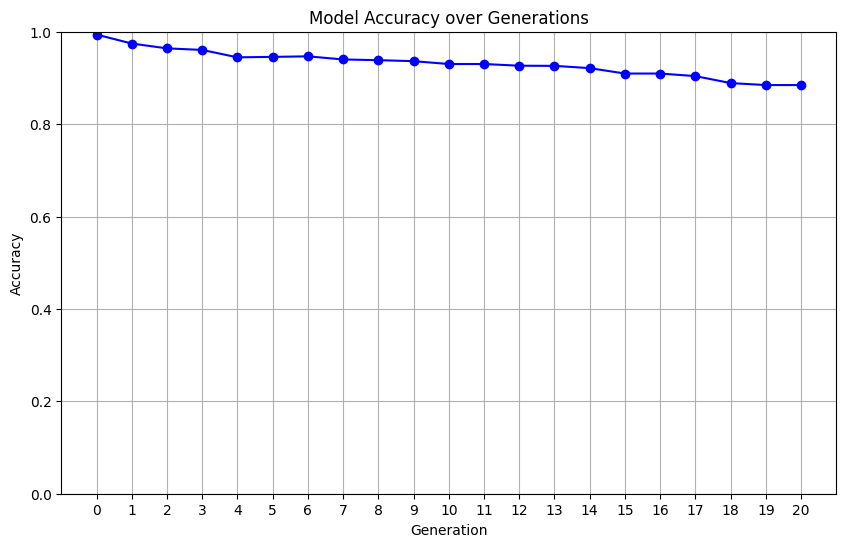

In [43]:
accuracies = []
accuracies.append(acc1)
iterations = []
iterations.append(0)

X_synthetic = generate_synthetic_features(rf_model, 3248, Xb1_train)

for i in range(1, 21):
    # Step 1: Generate new synthetic features based on current training set
    X_synthetic = generate_synthetic_features(rf_model, 3248, X_synthetic)
    
    # Step 2: Use the current model to predict labels for the synthetic data
    y_synthetic = rf_model.predict(X_synthetic)
    
    # Step 4: Train a new Random Forest model on the synthetic dataset
    rf_model = RandomForestClassifier(n_estimators=100)
    rf_model.fit(X_synthetic, y_synthetic)
    
    # Step 5: Evaluate the new model on the original fixed test set
    y_test_pred = rf_model.predict(Xb1_test)
    accuracy = accuracy_score(yb1_test, y_test_pred)
    
    # Print the iteration and accuracy
    print(f"Iteration {i}: Accuracy = {accuracy:.4f}")
    cm = confusion_matrix(y_true=yb1_test, y_pred=y_test_pred)
    print(f"Confusion Matrix:\n{cm}\n")
    
    # Append the accuracy and iteration number to the lists
    accuracies.append(accuracy)
    iterations.append(i)

# After the loop, plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(iterations, accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy over Generations')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.xticks(iterations)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

[[ 453  352]
 [  23 2420]]


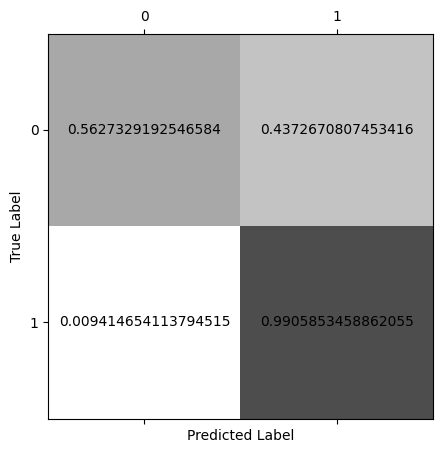

In [44]:
y_pred = rf_model.fit(X_synthetic, y_synthetic).predict(Xb1_test)
cm = confusion_matrix(y_true = yb1_test, y_pred = y_pred)
print(cm)

# Plot the Predicted Label vs. True Label accuracy matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig,ax = plt.subplots(figsize=(5,5))
ax.matshow(cmn, cmap=plt.cm.Greys, alpha=0.7)
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        ax.text(x=j, y=i, s=cmn[i,j], va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()